# Advanced Lane finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Compute the camera calibration matrix and distortion coefficients from chessboard images 

In the next cells the following is done:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import Line
import os
import MyTools

%matplotlib qt
%matplotlib inline

In [2]:
def GetImageAndObjectPoints(imgPaths, doPlots=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in imgPaths:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            if doPlots == True:
                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
                cv2.imshow('img', img)
                cv2.waitKey(500)

    if doPlots == True:
        cv2.destroyAllWindows()

    return imgpoints, objpoints

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, x_, y_ = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist


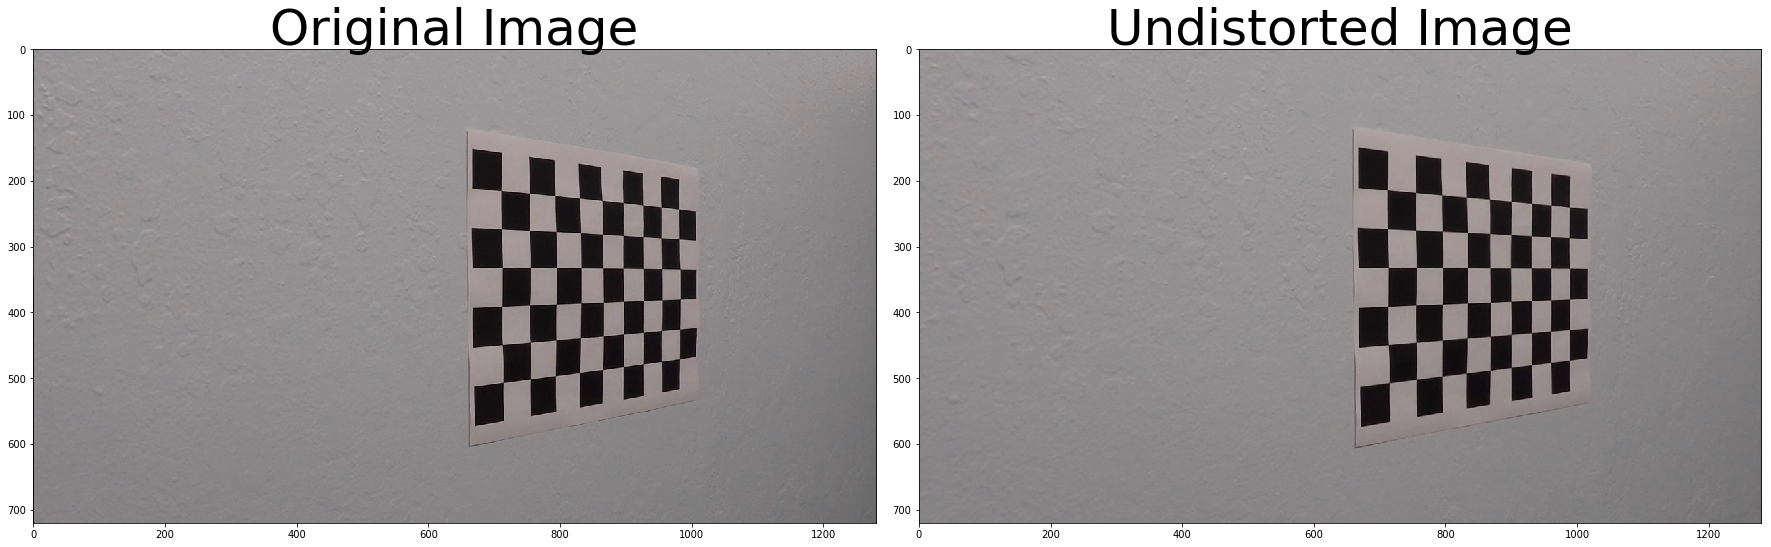

In [4]:
# ImgSavePath
imgSavePath = './output_images/'
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

imgpoints, objpoints = GetImageAndObjectPoints(images, doPlots=False)

# Use the objpoints and imgpoints found to Calibrate the camera and show result in an example image
img = cv2.imread(images[4])
img_undist, mtx, dist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Use color and gradient transforms to obtain a binary image
In the following, I use the following techniques to obtain a good binary image of the road:
* Color transform to HSV, using the S channel (best result)
* Then I run a canny transform to get a good binary image
* Merge the transformed images to a best candidate

In [5]:
# Load Test images and undistort
testImages = glob.glob('./test_images/test*.jpg')
testImage = './output_images/frame002.jpeg'  # testImages[0]
print('Image being used: ' + testImage)
img = cv2.imread(testImage)
img_undist = cv2.undistort(img, mtx, dist, None, mtx)

Image being used: ./output_images/frame002.jpeg


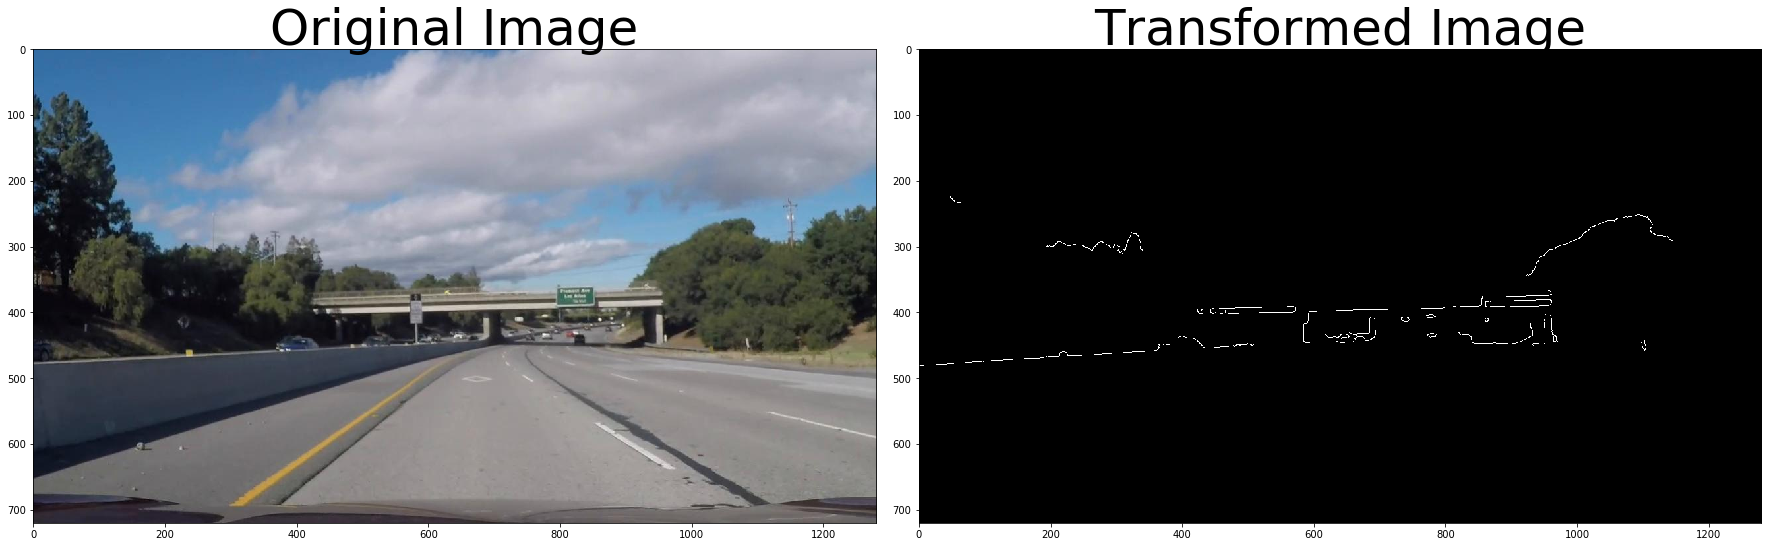

In [6]:
img_canny = MyTools.CannyDetect(img_undist)
# Plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_canny, 'gray')
ax2.set_title('Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

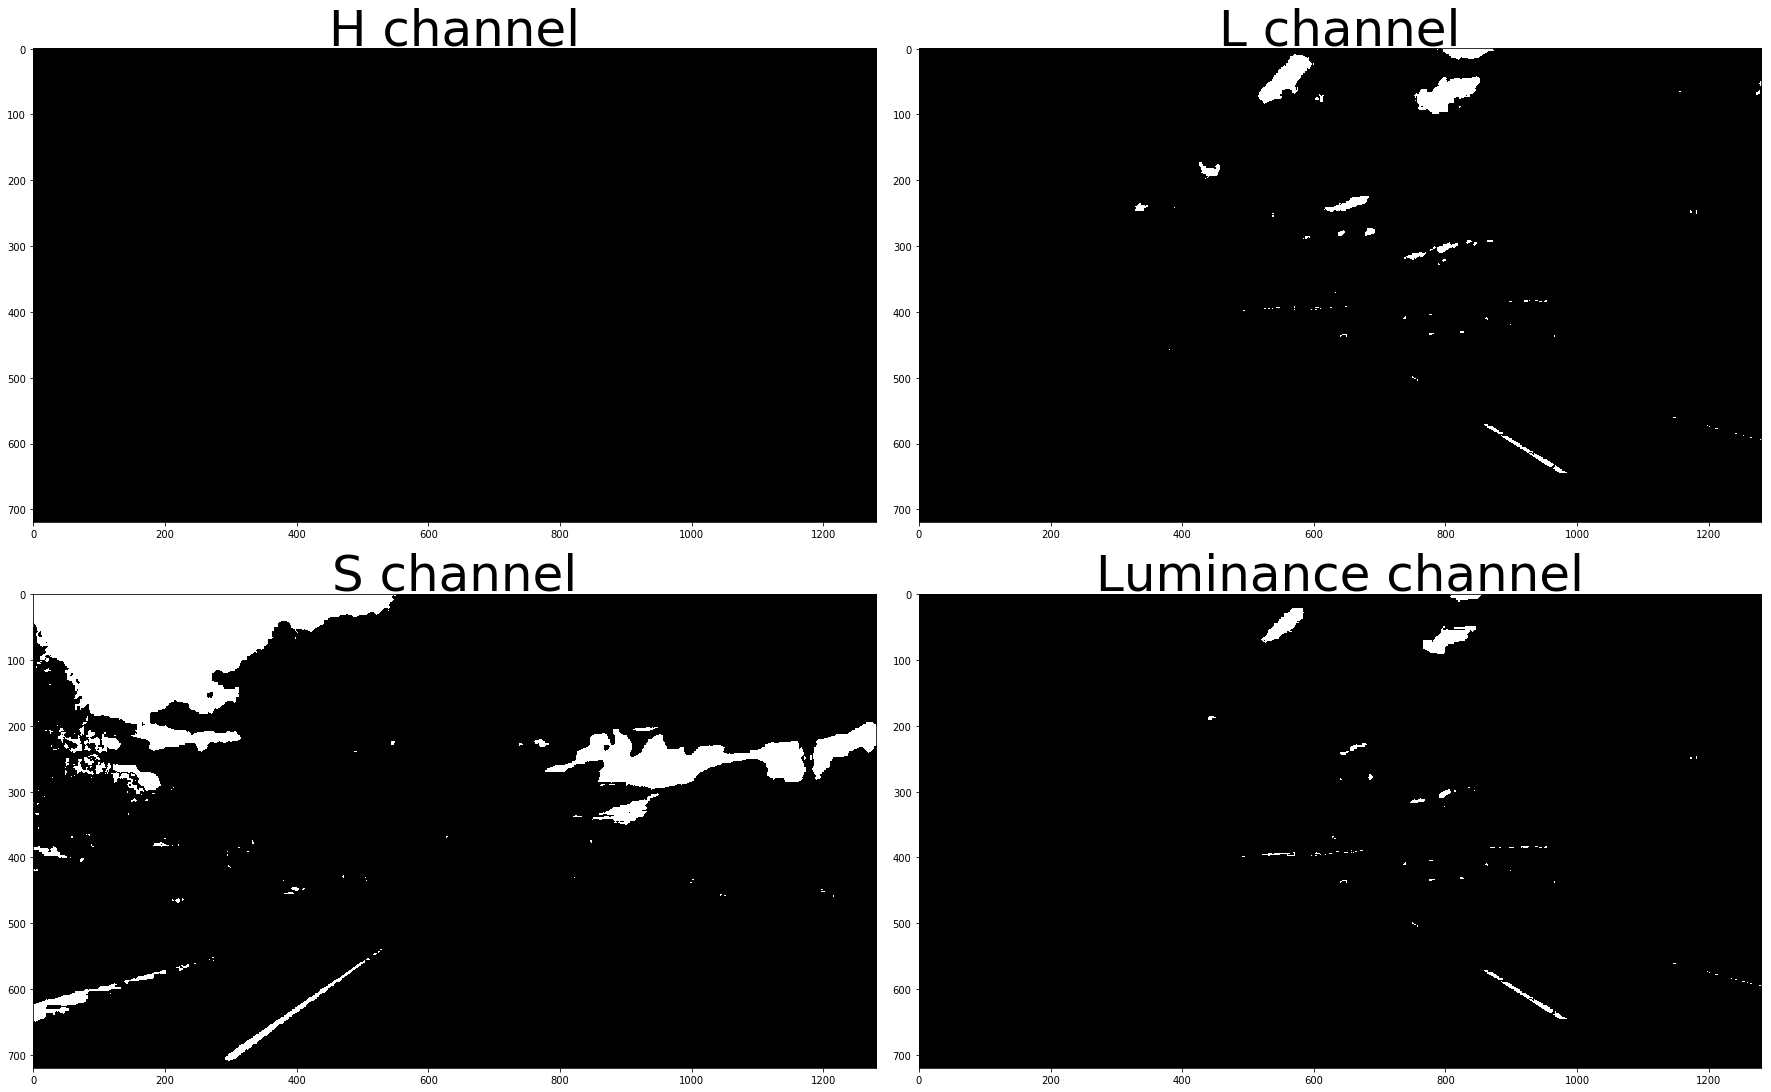

In [7]:
img_hls, h_channel, l_channel, s_channel, lum_channel = MyTools.ColorThreshold(img_undist)

# Plot results
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
ax1[0].imshow(h_channel,'gray')
ax1[0].set_title('H channel', fontsize=50)
ax1[1].imshow(l_channel,'gray')
ax1[1].set_title('L channel', fontsize=50)
ax2[0].imshow(s_channel,'gray')
ax2[0].set_title('S channel', fontsize=50)
ax2[1].imshow(lum_channel,'gray')
ax2[1].set_title('Luminance channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.6, bottom=0.)

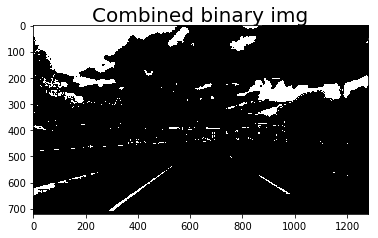

In [8]:
img_binary = MyTools.CombineBinaryImages(img_hls, img_canny)

plt.imshow(img_binary,'gray')
plt.title('Combined binary img', fontsize=20)

## Apply a perspective transform to rectify binary image ("birds-eye view")

* Using a straight road image, find the perspective transform lines (or rectangle points) that can be used to transform images with
* Apply perspective transform using the points find, and draw a rectangle on the image road, and transform the road image back



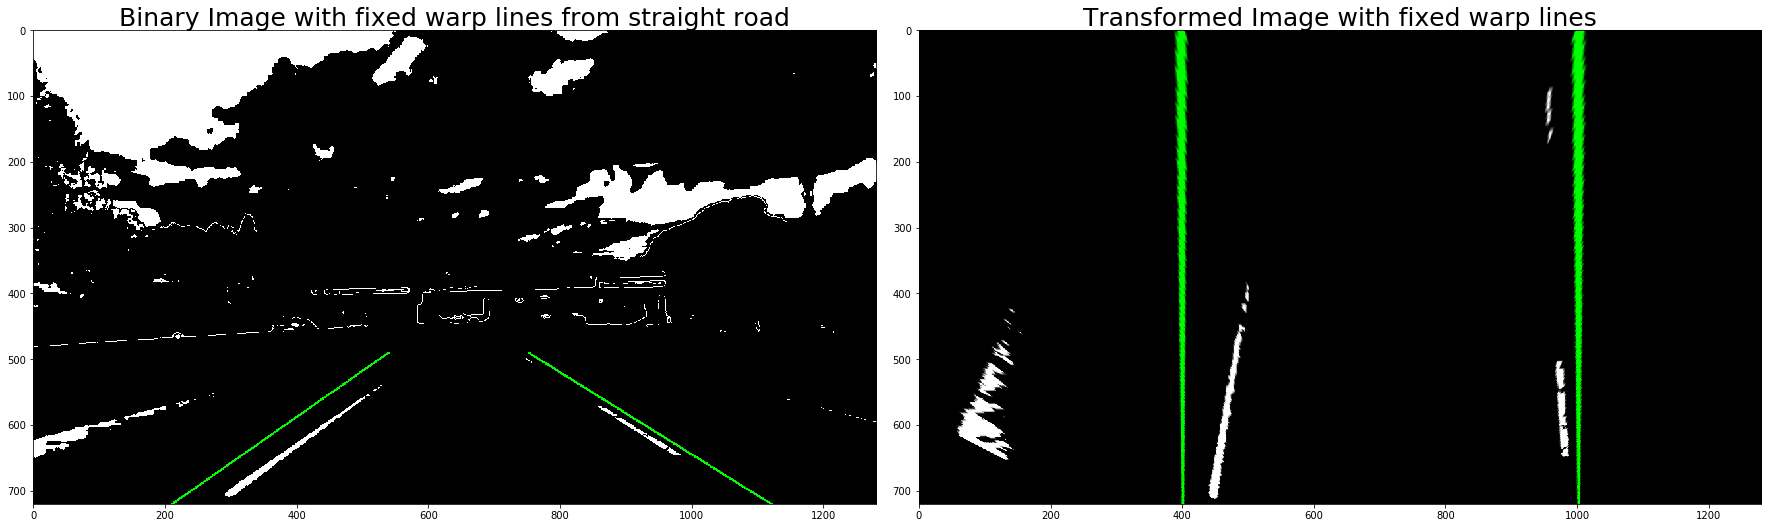

In [9]:
# Define some source points for perspective transform
dimY, dimX = img_binary.shape

#src = np.float32([(210, dimY),(590, 455),(695, 455),(1120, dimY)])
# destination points
dst = np.float32([(400, dimY),(400, 0),(1000, 0),(1000, dimY)])
src, dst = MyTools.CalculatePerspectiveTransform(img_binary.shape, 490)
    
# Create an image to draw the lines on
warp_lines = np.zeros_like(img_binary).astype(np.uint8)
warp_lines = np.dstack((warp_lines, warp_lines, warp_lines))
# Draw the lane onto the warped blank image
cv2.line(warp_lines, (src[0,0],src[0,1]), (src[1,0],src[1,1]),(0,255, 0),2)
cv2.line(warp_lines, (src[2,0],src[2,1]), (src[3,0],src[3,1]),(0,255, 0),2)

# Add Warp lines and binary image together as color image
img_binary_col = np.dstack((img_binary,img_binary,img_binary)) + warp_lines

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Warp the image using OpenCV warpPerspective()
img_warped_bin_col = cv2.warpPerspective(img_binary_col, M, (dimX, dimY))
img_warped_bin = cv2.warpPerspective(img_binary, M, (dimX, dimY))

# Save images
name = MyTools.GetFileNameFromFilePath(testImage)
MyTools.MyImageWrite(name + '_BinImgWLines.jpg', imgSavePath, img_binary_col)
MyTools.MyImageWrite(name + '_BinImgBirdsEye.jpg', imgSavePath, img_warped_bin_col)

# Plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_binary_col)
ax1.set_title('Binary Image with fixed warp lines from straight road', fontsize=25)
ax2.imshow(img_warped_bin_col)
ax2.set_title('Transformed Image with fixed warp lines', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

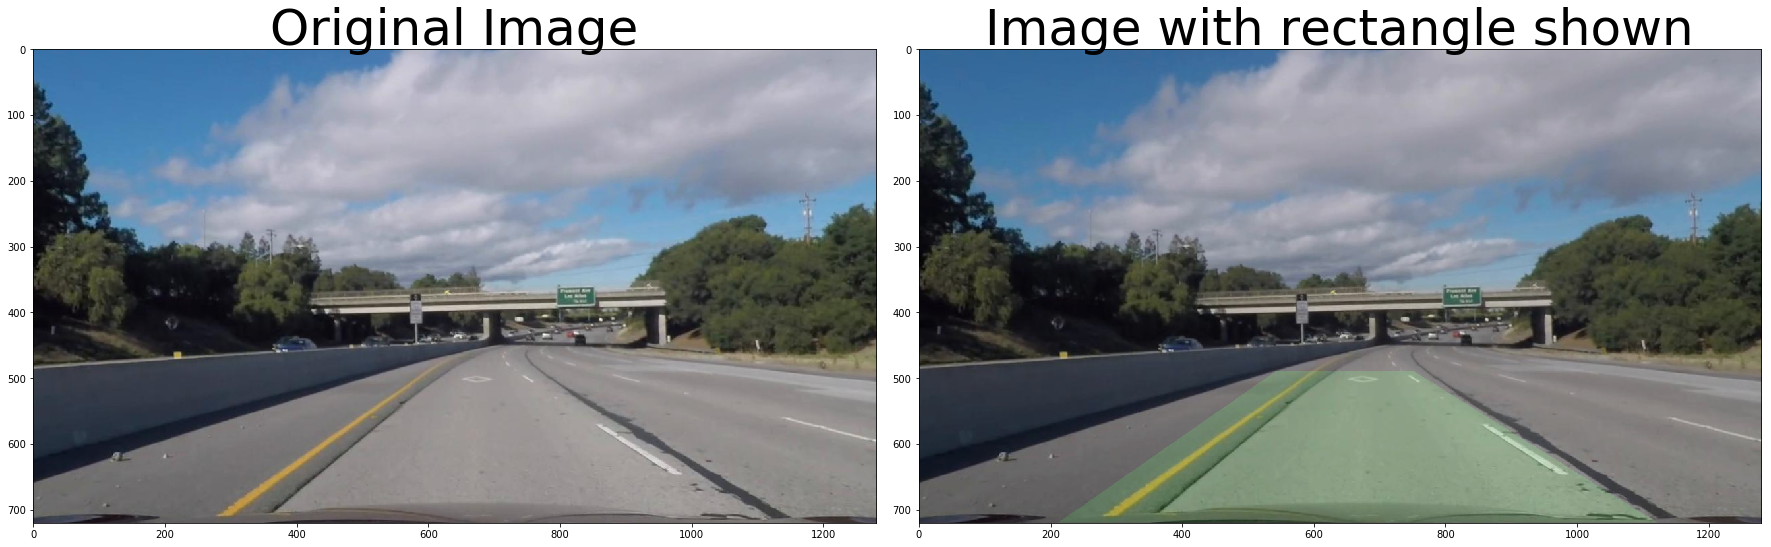

In [10]:
# Transform original image to birds eye, and apply a green rectangle and inverse transform image back to 
# drivers view

# Create rectangle image in birds eye view
img_rect = np.zeros_like(img_undist)
cv2.rectangle(img_rect, (dst[0,0],dst[0,1]), (dst[2,0],dst[2,1]), (0,255, 0),-1)
# Warp the rectangle using OpenCV warpPerspective() with inverse(M) 
img_rect_trans = cv2.warpPerspective(img_rect, np.linalg.inv(M), (dimX, dimY))

img_with_rect = cv2.addWeighted(img_undist, 0.9, img_rect_trans, 0.1, 0.0)

# Save images
name = MyTools.GetFileNameFromFilePath(testImage)
MyTools.MyImageWrite(name + '_ImageWRectangle.jpg', imgSavePath, img_with_rect)

# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(img_with_rect, cv2.COLOR_BGR2RGB))
ax2.set_title('Image with rectangle shown', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Calculate line curvature from lane pixels
Using the Line() class with the binary and birds eye transformed image the following is done:
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.

left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 1053 
Pixels found in left window: 1 pixels: 1062 
Pixels found in left window: 2 pixels: 982 
Pixels found in left window: 3 pixels: 567 
left lane detected: True
Pixels found in left poly pixels: 3664 
right lane, find line from scratch using windowing!!
Pixels found in right window: 1 pixels: 1049 
Pixels found in right window: 2 pixels: 696 
Pixels found in right window: 7 pixels: 657 
right lane detected: True
Pixels found in right poly pixels: 2402 
Left and right line search x-val start 446.89683988678314 and 985.8884410087104


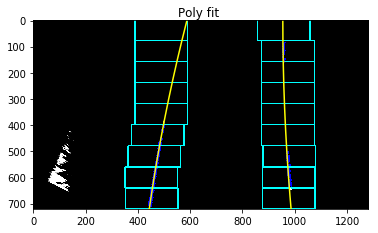

In [11]:
# get left and right lane Line objects:
LeftLane = Line.Line('left')
RightLane = Line.Line('right')

# Find lane pixels
LeftLane.find_lane_pixels(img_warped_bin)
RightLane.find_lane_pixels(img_warped_bin)
print('Left and right line search x-val start {} and {}'.format(LeftLane.bestx, RightLane.bestx))

img_plot = LeftLane.PlotPolynomialFit(img_warped_bin)
img_plot = RightLane.PlotPolynomialFit(img_plot)

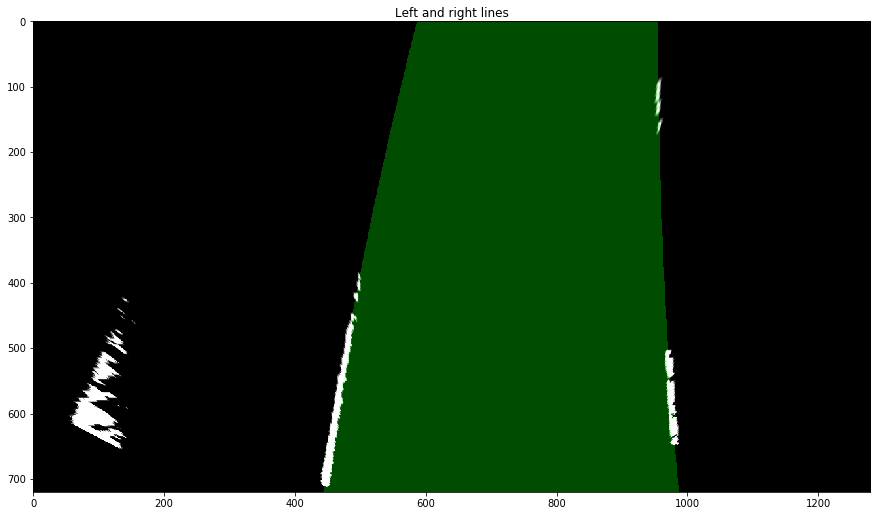

In [12]:
# Get image with green poly curve
img_polyfit = MyTools.BirdsEyeLaneFromLeftAndRightPolynomials(img_warped_bin, LeftLane.best_fit, RightLane.best_fit)

# Plot image ontop of binary warped image
MyTools.MergeAndPlotBGRImages(cv2.cvtColor(img_warped_bin, cv2.COLOR_GRAY2BGR), img_polyfit, 'Left and right lines')


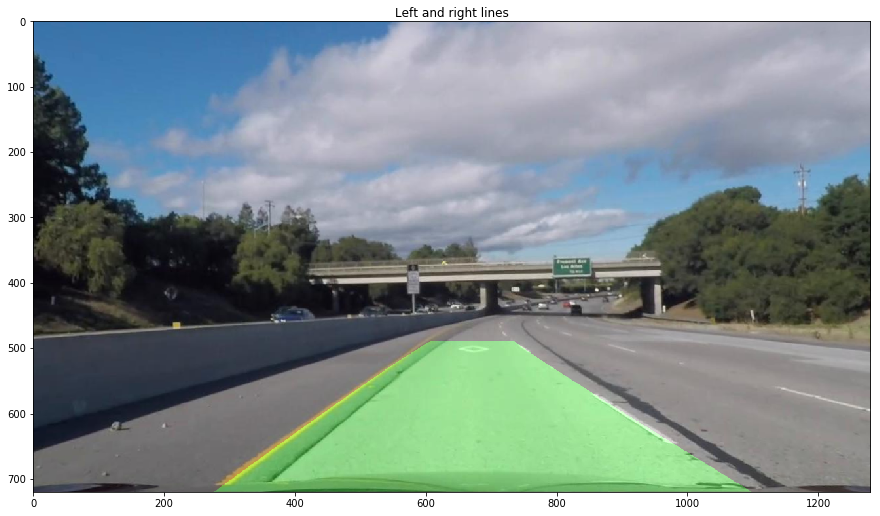

In [13]:
# Warp green poly curve image to drivers view
img_polyfit_warped = cv2.warpPerspective(img_polyfit, np.linalg.inv(M), (dimX, dimY))

# plot warped poly curve image ontop of road image
MyTools.MergeAndPlotBGRImages(img_undist, img_polyfit_warped, 'Left and right lines')

## Create Pipeline for video

In [16]:

    
def LanePipeline(img):
    dimY, dimX = img.shape[:2]
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)    
    img_canny  = MyTools.CannyDetect(img_undist)
    img_col, h_channel, l_channel, s_channel, lum = MyTools.ColorThreshold(img_undist)
    img_binary = MyTools.CombineBinaryImages(img_canny, img_col)
    img_warped = cv2.warpPerspective(img_binary, M, (dimX, dimY))
    
    # Get an estimate on the left and right base x values
    LeftLane.find_lane_pixels(img_warped)
    RightLane.find_lane_pixels(img_warped)  
    # Compare lane curvatures
    LeftLane.CompareLaneCurvatures(RightLane)
    
    img_polyfit = MyTools.BirdsEyeLaneFromLeftAndRightPolynomials(img_warped, LeftLane.best_fit, RightLane.best_fit)
    img_polyfit_warped = cv2.warpPerspective(img_polyfit, np.linalg.inv(M), (dimX, dimY))

    LaneOffset = 'Offset:       {:.2f}m'.format(MyTools.CalculateLaneOffset(LeftLane,RightLane))
    LaneCurveL = 'Radius Left:  {:.0f}m'.format(LeftLane.radius_of_curvature)
    LaneCurveR = 'Radius Right: {:.0f}m'.format(RightLane.radius_of_curvature)
    BadLFrame = 'Bad frame L: {}'.format(LeftLane.NrOfBadFrames)
    BadRFrame = 'Bad frame R: {}'.format(RightLane.NrOfBadFrames)
    cv2.putText(img_undist, LaneOffset, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),3)
    cv2.putText(img_undist, LaneCurveL, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),3)    
    cv2.putText(img_undist, LaneCurveR, (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),3)
    cv2.putText(img_undist, BadLFrame, (700,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),3)
    cv2.putText(img_undist, BadRFrame, (700,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),3)
    
    if debug == 0:
        img_out = cv2.addWeighted(img_undist, 1, img_polyfit_warped, 0.3, 0)   
    #MyTools.MergeAndPlotBGRImages(img_undist, img_polyfit_warped, 'Left and right lines')
    else:
        img_out = LeftLane.PlotPolynomialFit(img_warped,plot=0)
        img_out = RightLane.PlotPolynomialFit(img_out,plot=0)
        
    return img_out
    

left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 1053 
Pixels found in left window: 1 pixels: 1062 
Pixels found in left window: 2 pixels: 982 
Pixels found in left window: 3 pixels: 567 
left lane detected: True
Pixels found in left poly pixels: 3664 
right lane, find line from scratch using windowing!!
Pixels found in right window: 1 pixels: 1049 
Pixels found in right window: 2 pixels: 696 
Pixels found in right window: 7 pixels: 657 
right lane detected: True
Pixels found in right poly pixels: 2402 
Pixels found in left poly pixels: 3750 
Pixels found in right poly pixels: 2593 


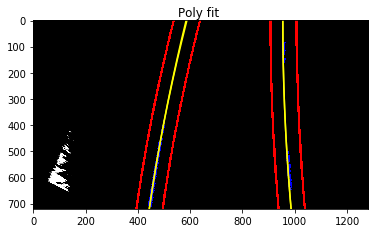

In [15]:
# get left and right lane Line objects:
LeftLane = Line.Line('left')
RightLane = Line.Line('right')
testImage = './output_images/frame002.jpeg'
img = cv2.imread(testImage)

for n in range(2):
    img_out = LanePipeline(img);
    #cv2.imshow('img',img_out)
    LeftLane.PlotPolynomialFit(img_out,plot=1)
    RightLane.PlotPolynomialFit(img_out,plot=1)
    cv2.waitKey(2000)
    #cv2.destroyAllWindows()

In [ ]:
print(len(LeftLane.allx))
print(len(RightLane.allx))
plt.scatter(RightLane.allx, 750 - RightLane.ally,color='yellow',s=1)
plt.xlim([0,1300])
plt.hold
plt.scatter(LeftLane.allx, 750 - LeftLane.ally,color='yellow',s=0.1)

In [17]:
# Run Lane pipeline on videoclip
debug = 1
LeftLane = Line.Line('left')
RightLane = Line.Line('right')
MyTools.ProcessVideo('./challenge_video.mp4', './output_images/', LanePipeline)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 1204 
Pixels found in left window: 1 pixels: 1313 
Pixels found in left window: 2 pixels: 1245 
Pixels found in left window: 3 pixels: 1207 
Pixels found in left window: 4 pixels: 1270 
Pixels found in left window: 5 pixels: 682 
left lane detected: True
Pixels found in left poly pixels: 6921 
right lane, find line from scratch using windowing!!
Pixels found in right window: 1 pixels: 1300 
Pixels found in right window: 2 pixels: 1361 
Pixels found in right window: 3 pixels: 586 
Pixels found in right window: 4 pixels: 652 
Pixels found in right window: 5 pixels: 789 
Pixels found in right window: 6 pixels: 713 
right lane detected: True
Pixels found in right poly pixels: 5401 
Moviepy - Building video ./output_images/challenge_video.mp4.
Moviepy - Writing video ./output_images/challenge_video.mp4

Pixels found in left poly pixels: 7024 
Pixels found in right poly pixels: 5702 


t:   1%|          | 4/485 [00:00<00:37, 12.86it/s, now=None]

Pixels found in left poly pixels: 6771 
Pixels found in right poly pixels: 5454 
Pixels found in left poly pixels: 6807 
Pixels found in right poly pixels: 5181 


t:   1%|          | 6/485 [00:00<00:43, 11.12it/s, now=None]

Pixels found in left poly pixels: 6375 
Pixels found in right poly pixels: 4699 
Pixels found in left poly pixels: 6017 
Pixels found in right poly pixels: 2165 
Pixels found in left poly pixels: 5749 


t:   2%|▏         | 8/485 [00:00<00:43, 11.09it/s, now=None]

Pixels found in right poly pixels: 1425 
Pixels found in left poly pixels: 5626 
Pixels found in right poly pixels: 20 
right lineCurvature: 9690208, x-poly: 906, x_diff: 102.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 4981 


t:   2%|▏         | 11/485 [00:00<00:45, 10.46it/s, now=None]

Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1008.6, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5055 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1008.6, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 4771 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1008.6, badPos: True, Too few pixels: True, lane detected: True


t:   3%|▎         | 14/485 [00:01<00:44, 10.63it/s, now=None]

Pixels found in left poly pixels: 4708 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1008.6, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 4796 
Pixels found in right poly pixels: 21 
right lineCurvature: 86451235183, x-poly: 813, x_diff: 195.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 4425 
Pixels found in right poly pixels: 97 
right lineCurvature: 4, x-poly: 130, x_diff: 878.1, badPos: True, Too few pixels: True, lane detected: True


t:   3%|▎         | 16/485 [00:01<00:44, 10.46it/s, now=None]

Pixels found in left poly pixels: 4214 
Pixels found in right poly pixels: 165 
right lineCurvature: 191, x-poly: 1127, x_diff: 118.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 4584 
Pixels found in right poly pixels: 214 
right lineCurvature: 3778, x-poly: 1007, x_diff: 2.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 4346 
Pixels found in right poly pixels: 479 
right lineCurvature: 1907, x-poly: 1014, x_diff: 5.3, badPos: False, Too few pixels: True, lane detected: True


t:   4%|▎         | 18/485 [00:01<00:43, 10.66it/s, now=None]

Pixels found in left poly pixels: 4120 
Pixels found in right poly pixels: 759 
right lineCurvature: 2237, x-poly: 1010, x_diff: 1.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 4067 
Pixels found in right poly pixels: 1014 
right lineCurvature: 2699, x-poly: 1005, x_diff: 4.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 3944 
Pixels found in right poly pixels: 7181 


t:   5%|▍         | 22/485 [00:02<00:45, 10.21it/s, now=None]

Pixels found in left poly pixels: 4085 
Pixels found in right poly pixels: 1720 
Pixels found in left poly pixels: 4343 
Pixels found in right poly pixels: 1866 
Pixels found in left poly pixels: 4113 


t:   5%|▍         | 24/485 [00:02<00:45, 10.13it/s, now=None]

Pixels found in right poly pixels: 1488 
Pixels found in left poly pixels: 4180 
Pixels found in right poly pixels: 1645 
Pixels found in left poly pixels: 8924 


t:   5%|▌         | 26/485 [00:02<00:45, 10.07it/s, now=None]

Pixels found in right poly pixels: 1657 
Pixels found in left poly pixels: 4260 
Pixels found in right poly pixels: 2207 
Pixels found in left poly pixels: 4789 


t:   6%|▌         | 28/485 [00:02<00:45, 10.01it/s, now=None]

Pixels found in right poly pixels: 1632 
Pixels found in left poly pixels: 4801 
Pixels found in right poly pixels: 1821 
Pixels found in left poly pixels: 4656 
Pixels found in right poly pixels: 1997 


t:   7%|▋         | 32/485 [00:03<00:43, 10.41it/s, now=None]

Pixels found in left poly pixels: 4452 
Pixels found in right poly pixels: 2244 
Pixels found in left poly pixels: 4413 
Pixels found in right poly pixels: 2603 
Pixels found in left poly pixels: 5270 
Pixels found in right poly pixels: 3104 


t:   7%|▋         | 34/485 [00:03<00:44, 10.24it/s, now=None]

Pixels found in left poly pixels: 4537 
Pixels found in right poly pixels: 2775 
Pixels found in left poly pixels: 4280 
Pixels found in right poly pixels: 2463 
Pixels found in left poly pixels: 4419 


t:   7%|▋         | 36/485 [00:03<00:42, 10.55it/s, now=None]

Pixels found in right poly pixels: 1773 
Pixels found in left poly pixels: 4423 
Pixels found in right poly pixels: 1354 
Pixels found in left poly pixels: 4264 
Pixels found in right poly pixels: 1266 


t:   8%|▊         | 38/485 [00:03<00:43, 10.34it/s, now=None]

Pixels found in left poly pixels: 4150 
Pixels found in right poly pixels: 1234 
Pixels found in left poly pixels: 4168 
Pixels found in right poly pixels: 1415 
Pixels found in left poly pixels: 4346 


t:   8%|▊         | 40/485 [00:03<00:43, 10.18it/s, now=None]

Pixels found in right poly pixels: 1499 
Pixels found in left poly pixels: 4167 
Pixels found in right poly pixels: 1912 
Pixels found in left poly pixels: 4451 
Pixels found in right poly pixels: 2214 


t:   9%|▉         | 44/485 [00:04<00:42, 10.33it/s, now=None]

Pixels found in left poly pixels: 4898 
Pixels found in right poly pixels: 2363 
Pixels found in left poly pixels: 4889 
Pixels found in right poly pixels: 2602 
Pixels found in left poly pixels: 4400 
Pixels found in right poly pixels: 2717 


t:  10%|▉         | 48/485 [00:04<00:41, 10.41it/s, now=None]

Pixels found in left poly pixels: 4130 
Pixels found in right poly pixels: 2966 
Pixels found in left poly pixels: 4205 
Pixels found in right poly pixels: 2856 
Pixels found in left poly pixels: 3933 
Pixels found in right poly pixels: 2509 


t:  10%|█         | 50/485 [00:04<00:42, 10.19it/s, now=None]

Pixels found in left poly pixels: 3659 
Pixels found in right poly pixels: 1905 
Pixels found in left poly pixels: 3203 
Pixels found in right poly pixels: 1602 


t:  11%|█         | 52/485 [00:04<00:43,  9.97it/s, now=None]

Pixels found in left poly pixels: 3122 
Pixels found in right poly pixels: 1376 
Pixels found in left poly pixels: 3099 
Pixels found in right poly pixels: 1410 


t:  11%|█         | 54/485 [00:05<00:43,  9.88it/s, now=None]

Pixels found in left poly pixels: 2800 
Pixels found in right poly pixels: 1730 
Pixels found in left poly pixels: 2799 
Pixels found in right poly pixels: 2026 
Pixels found in left poly pixels: 2973 


t:  12%|█▏        | 56/485 [00:05<00:41, 10.22it/s, now=None]

Pixels found in right poly pixels: 2251 
Pixels found in left poly pixels: 2981 
Pixels found in right poly pixels: 2450 
Pixels found in left poly pixels: 2758 
Pixels found in right poly pixels: 2552 


t:  12%|█▏        | 59/485 [00:05<00:43,  9.88it/s, now=None]

Pixels found in left poly pixels: 2330 
Pixels found in right poly pixels: 2733 
Pixels found in left poly pixels: 2395 
Pixels found in right poly pixels: 2795 


t:  12%|█▏        | 60/485 [00:05<00:44,  9.49it/s, now=None]

Pixels found in left poly pixels: 2239 
Pixels found in right poly pixels: 2912 
Pixels found in left poly pixels: 2176 
Pixels found in right poly pixels: 2974 
Pixels found in left poly pixels: 2912 


t:  13%|█▎        | 62/485 [00:05<00:43,  9.78it/s, now=None]

Pixels found in right poly pixels: 2399 
Pixels found in left poly pixels: 2373 
Pixels found in right poly pixels: 2016 
Pixels found in left poly pixels: 2080 
Pixels found in right poly pixels: 1533 


t:  13%|█▎        | 65/485 [00:06<00:44,  9.43it/s, now=None]

Pixels found in left poly pixels: 1584 
Pixels found in right poly pixels: 1330 
Pixels found in left poly pixels: 1711 
Pixels found in right poly pixels: 1447 
Pixels found in left poly pixels: 1811 


t:  14%|█▍        | 68/485 [00:06<00:43,  9.59it/s, now=None]

Pixels found in right poly pixels: 1703 
Pixels found in left poly pixels: 1863 
Pixels found in right poly pixels: 2055 


t:  14%|█▍        | 69/485 [00:06<00:43,  9.58it/s, now=None]

Pixels found in left poly pixels: 2583 
Pixels found in right poly pixels: 2416 
Pixels found in left poly pixels: 2982 
Pixels found in right poly pixels: 2457 


t:  15%|█▌        | 73/485 [00:07<00:41, 10.01it/s, now=None]

Pixels found in left poly pixels: 2884 
Pixels found in right poly pixels: 2601 
Pixels found in left poly pixels: 2902 
Pixels found in right poly pixels: 2915 
Pixels found in left poly pixels: 2988 
Pixels found in right poly pixels: 3127 


t:  15%|█▌        | 75/485 [00:07<00:41,  9.77it/s, now=None]

Pixels found in left poly pixels: 2969 
Pixels found in right poly pixels: 3161 
Pixels found in left poly pixels: 2870 
Pixels found in right poly pixels: 3486 
Pixels found in left poly pixels: 3076 
Pixels found in right poly pixels: 2966 


t:  16%|█▌        | 77/485 [00:07<00:40, 10.02it/s, now=None]

Pixels found in left poly pixels: 2882 
Pixels found in right poly pixels: 2489 
Pixels found in left poly pixels: 2790 
Pixels found in right poly pixels: 2035 
Pixels found in left poly pixels: 2259 


t:  17%|█▋        | 81/485 [00:07<00:39, 10.27it/s, now=None]

Pixels found in right poly pixels: 1700 
Pixels found in left poly pixels: 2014 
Pixels found in right poly pixels: 1784 
Pixels found in left poly pixels: 1631 
Pixels found in right poly pixels: 1896 


t:  17%|█▋        | 83/485 [00:08<00:38, 10.50it/s, now=None]

Pixels found in left poly pixels: 1378 
Pixels found in right poly pixels: 1978 
Pixels found in left poly pixels: 1010 
left lineCurvature: 4961, x-poly: 434, x_diff: 8.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2219 
Pixels found in left poly pixels: 634 
left lineCurvature: 3496, x-poly: 433, x_diff: 7.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2609 


t:  18%|█▊        | 85/485 [00:08<00:38, 10.48it/s, now=None]

Pixels found in left poly pixels: 810 
left lineCurvature: 6437, x-poly: 432, x_diff: 6.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2884 
Pixels found in left poly pixels: 837 
left lineCurvature: 4914, x-poly: 433, x_diff: 7.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3389 


t:  18%|█▊        | 87/485 [00:08<00:39, 10.18it/s, now=None]

Pixels found in left poly pixels: 960 
left lineCurvature: 829, x-poly: 435, x_diff: 9.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3548 
Pixels found in left poly pixels: 1091 
left lineCurvature: 376, x-poly: 440, x_diff: 14.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3602 
Pixels found in left poly pixels: 1553 


t:  18%|█▊        | 89/485 [00:08<00:38, 10.29it/s, now=None]

Pixels found in right poly pixels: 3209 
Pixels found in left poly pixels: 1373 
Pixels found in right poly pixels: 2799 


t:  19%|█▉        | 91/485 [00:08<00:39, 10.02it/s, now=None]

Pixels found in left poly pixels: 1557 
Pixels found in right poly pixels: 2280 
Pixels found in left poly pixels: 2116 
Pixels found in right poly pixels: 1872 
Pixels found in left poly pixels: 1364 
Pixels found in right poly pixels: 1682 


t:  20%|█▉        | 95/485 [00:09<00:38, 10.22it/s, now=None]

Pixels found in left poly pixels: 1259 
Pixels found in right poly pixels: 1746 
Pixels found in left poly pixels: 1355 
Pixels found in right poly pixels: 1837 
Pixels found in left poly pixels: 1009 
left lineCurvature: 1847, x-poly: 436, x_diff: 8.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1876 


t:  20%|██        | 97/485 [00:09<00:37, 10.22it/s, now=None]

Pixels found in left poly pixels: 1085 
left lineCurvature: 1394, x-poly: 438, x_diff: 10.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2313 
Pixels found in left poly pixels: 1695 
Pixels found in right poly pixels: 2787 


t:  20%|██        | 99/485 [00:09<00:41,  9.40it/s, now=None]

Pixels found in left poly pixels: 7276 
Pixels found in right poly pixels: 2842 
Pixels found in left poly pixels: 8367 
Pixels found in right poly pixels: 2998 


t:  21%|██        | 102/485 [00:10<00:39,  9.61it/s, now=None]

Pixels found in left poly pixels: 8574 
Pixels found in right poly pixels: 3146 
Pixels found in left poly pixels: 5818 
Pixels found in right poly pixels: 3473 


t:  21%|██        | 103/485 [00:10<00:40,  9.50it/s, now=None]

Pixels found in left poly pixels: 3523 
Pixels found in right poly pixels: 3449 
Pixels found in left poly pixels: 3749 
Pixels found in right poly pixels: 2892 
Pixels found in left poly pixels: 2959 
Pixels found in right poly pixels: 2724 


t:  22%|██▏       | 108/485 [00:10<00:37, 10.14it/s, now=None]

Pixels found in left poly pixels: 3462 
Pixels found in right poly pixels: 2200 
Pixels found in left poly pixels: 2995 
Pixels found in right poly pixels: 2009 
Pixels found in left poly pixels: 3084 
Pixels found in right poly pixels: 2175 


t:  23%|██▎       | 110/485 [00:10<00:36, 10.39it/s, now=None]

Pixels found in left poly pixels: 2844 
Pixels found in right poly pixels: 2131 
Pixels found in left poly pixels: 3470 
Pixels found in right poly pixels: 2015 
Pixels found in left poly pixels: 5075 
Pixels found in right poly pixels: 2442 


t:  23%|██▎       | 112/485 [00:10<00:35, 10.42it/s, now=None]

Pixels found in left poly pixels: 6163 
Pixels found in right poly pixels: 3274 
Pixels found in left poly pixels: 6534 
Pixels found in right poly pixels: 3824 


t:  24%|██▎       | 114/485 [00:11<00:36, 10.22it/s, now=None]

Pixels found in left poly pixels: 7826 
Pixels found in right poly pixels: 6084 
Pixels found in left poly pixels: 8658 
Pixels found in right poly pixels: 6414 


t:  24%|██▍       | 117/485 [00:11<00:38,  9.54it/s, now=None]

Pixels found in left poly pixels: 7990 
Pixels found in right poly pixels: 7156 
Pixels found in left poly pixels: 8154 
Pixels found in right poly pixels: 7138 


t:  25%|██▍       | 119/485 [00:11<00:36,  9.94it/s, now=None]

Pixels found in left poly pixels: 8726 
Pixels found in right poly pixels: 6074 
Pixels found in left poly pixels: 9240 
Pixels found in right poly pixels: 5752 
Pixels found in left poly pixels: 8910 
Pixels found in right poly pixels: 4375 


t:  25%|██▍       | 121/485 [00:11<00:35, 10.23it/s, now=None]

Pixels found in left poly pixels: 8367 
Pixels found in right poly pixels: 3973 
Pixels found in left poly pixels: 8183 
Pixels found in right poly pixels: 3888 
Pixels found in left poly pixels: 7481 


t:  25%|██▌       | 123/485 [00:12<00:35, 10.28it/s, now=None]

Pixels found in right poly pixels: 3693 
Pixels found in left poly pixels: 6821 
Pixels found in right poly pixels: 3660 
Pixels found in left poly pixels: 6115 
Pixels found in right poly pixels: 3574 


t:  26%|██▌       | 127/485 [00:12<00:35, 10.12it/s, now=None]

Pixels found in left poly pixels: 5761 
Pixels found in right poly pixels: 3470 
Pixels found in left poly pixels: 4919 
Pixels found in right poly pixels: 3333 
Pixels found in left poly pixels: 4252 


t:  27%|██▋       | 129/485 [00:12<00:34, 10.28it/s, now=None]

Pixels found in right poly pixels: 3262 
Pixels found in left poly pixels: 5024 
Pixels found in right poly pixels: 3222 
Pixels found in left poly pixels: 3527 
Pixels found in right poly pixels: 3174 


t:  27%|██▋       | 131/485 [00:12<00:33, 10.49it/s, now=None]

Pixels found in left poly pixels: 3099 
Pixels found in right poly pixels: 2731 
Pixels found in left poly pixels: 2445 
Pixels found in right poly pixels: 1893 
right lineCurvature: 45, x-poly: 952, x_diff: 1.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 2857 
left lineCurvature: 65, x-poly: 431, x_diff: 27.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 1272 


t:  27%|██▋       | 133/485 [00:13<00:33, 10.43it/s, now=None]

right lineCurvature: 90, x-poly: 947, x_diff: 6.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 2097 
left lineCurvature: 53, x-poly: 450, x_diff: 7.8, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 473 
right lineCurvature: 130, x-poly: 969, x_diff: 16.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 3593 


t:  28%|██▊       | 137/485 [00:13<00:33, 10.31it/s, now=None]

Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 952.9, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 3370 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 952.9, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 2603 
left lineCurvature: 92, x-poly: 432, x_diff: 24.8, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 952.9, badPos: True, Too few pixels: True, lane detected: True


t:  29%|██▊       | 139/485 [00:13<00:33, 10.28it/s, now=None]

Pixels found in left poly pixels: 4257 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 952.9, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 3599 
Pixels found in right poly pixels: 2041 
right lineCurvature: 105, x-poly: 7564, x_diff: 6610.9, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high, new detection needed!
Pixels found in left poly pixels: 5387 
Pixels found in right poly pixels: 3150 
right lineCurvature: 119, x-poly: 16459, x_diff: 15505.9, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high, new detection needed!


t:  29%|██▉       | 141/485 [00:13<00:33, 10.16it/s, now=None]

Pixels found in left poly pixels: 2787 
Pixels found in right poly pixels: 3571 
right lineCurvature: 105, x-poly: 5846, x_diff: 4893.4, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high, new detection needed!
Pixels found in left poly pixels: 4190 
Pixels found in right poly pixels: 4106 
right lineCurvature: 143, x-poly: 2235, x_diff: 1281.9, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high, new detection needed!


t:  30%|██▉       | 144/485 [00:14<00:35,  9.57it/s, now=None]

Pixels found in left poly pixels: 2967 
Pixels found in right poly pixels: 3976 
right lineCurvature: 189, x-poly: 1617, x_diff: 663.9, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high, new detection needed!
Pixels found in left poly pixels: 1855 
Pixels found in right poly pixels: 3925 
Lane curvature difference too high, new detection needed!


t:  30%|███       | 146/485 [00:14<00:34,  9.76it/s, now=None]

Pixels found in left poly pixels: 7 
left lineCurvature: 10000, x-poly: 0, x_diff: 455.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4097 
right lineCurvature: 241, x-poly: 1310, x_diff: 356.1, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high, new detection needed!
Pixels found in left poly pixels: 1560 
left lineCurvature: 7, x-poly: 167, x_diff: 287.8, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 4341 
right lineCurvature: 322, x-poly: 687, x_diff: 266.5, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high, new detection needed!


t:  30%|███       | 147/485 [00:14<00:36,  9.36it/s, now=None]

Pixels found in left poly pixels: 1484 
left lineCurvature: 25, x-poly: 421, x_diff: 34.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 4914 
Lane curvature difference too high, new detection needed!
Pixels found in left poly pixels: 1325 
left lineCurvature: 13, x-poly: 428, x_diff: 27.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 6770 
Lane curvature difference too high, new detection needed!


t:  31%|███       | 150/485 [00:14<00:36,  9.21it/s, now=None]

Pixels found in left poly pixels: 2157 
Pixels found in right poly pixels: 9305 
Lane curvature difference too high, new detection needed!
Pixels found in left poly pixels: 2216 
Pixels found in right poly pixels: 9074 
right lineCurvature: 344, x-poly: 771, x_diff: 176.4, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high, new detection needed!


t:  31%|███▏      | 152/485 [00:14<00:34,  9.59it/s, now=None]

Pixels found in left poly pixels: 2307 
Pixels found in right poly pixels: 7209 
Lane curvature difference too high, new detection needed!
Pixels found in left poly pixels: 4591 
Pixels found in right poly pixels: 5339 
Lane curvature difference too high, new detection needed!


t:  32%|███▏      | 154/485 [00:15<00:35,  9.39it/s, now=None]

Pixels found in left poly pixels: 5416 
Pixels found in right poly pixels: 5598 
Lane curvature difference too high, new detection needed!
Pixels found in left poly pixels: 6174 
Pixels found in right poly pixels: 6322 
Lane curvature difference too high, new detection needed!


t:  32%|███▏      | 156/485 [00:15<00:36,  9.02it/s, now=None]

Pixels found in left poly pixels: 6297 
Pixels found in right poly pixels: 6672 
Lane curvature difference too high, new detection needed!
Pixels found in left poly pixels: 5914 
Pixels found in right poly pixels: 6760 
Lane curvature difference too high, new detection needed!


t:  33%|███▎      | 158/485 [00:15<00:36,  8.84it/s, now=None]

Pixels found in left poly pixels: 6751 
Pixels found in right poly pixels: 7062 
Lane curvature difference too high, new detection needed!
Pixels found in left poly pixels: 6936 
Pixels found in right poly pixels: 6952 
Lane curvature difference too high, new detection needed!


t:  33%|███▎      | 160/485 [00:15<00:36,  8.80it/s, now=None]

Pixels found in left poly pixels: 5635 
Pixels found in right poly pixels: 6304 
Lane curvature difference too high, new detection needed!
Pixels found in left poly pixels: 5363 
Pixels found in right poly pixels: 5374 
Lane curvature difference too high, new detection needed!


t:  33%|███▎      | 162/485 [00:16<00:35,  9.15it/s, now=None]

Pixels found in left poly pixels: 5358 
Pixels found in right poly pixels: 4582 
Lane curvature difference too high, new detection needed!
Pixels found in left poly pixels: 5264 
Pixels found in right poly pixels: 3743 
Lane curvature difference too high, new detection needed!
Pixels found in left poly pixels: 5279 


t:  34%|███▍      | 164/485 [00:16<00:33,  9.59it/s, now=None]

Pixels found in right poly pixels: 3583 
Lane curvature difference too high, new detection needed!
Pixels found in left poly pixels: 5391 
Pixels found in right poly pixels: 3385 
Pixels found in left poly pixels: 5253 
Pixels found in right poly pixels: 3378 


t:  34%|███▍      | 167/485 [00:16<00:32,  9.68it/s, now=None]

Pixels found in left poly pixels: 5374 
Pixels found in right poly pixels: 3705 
Pixels found in left poly pixels: 5471 
Pixels found in right poly pixels: 4541 


t:  35%|███▍      | 169/485 [00:16<00:32,  9.65it/s, now=None]

Pixels found in left poly pixels: 5413 
Pixels found in right poly pixels: 4992 
Pixels found in left poly pixels: 5398 
Pixels found in right poly pixels: 5617 


t:  35%|███▌      | 171/485 [00:17<00:34,  9.23it/s, now=None]

Pixels found in left poly pixels: 5431 
Pixels found in right poly pixels: 5903 
Pixels found in left poly pixels: 5637 
Pixels found in right poly pixels: 5668 


t:  36%|███▌      | 173/485 [00:17<00:33,  9.45it/s, now=None]

Pixels found in left poly pixels: 5573 
Pixels found in right poly pixels: 5450 
Pixels found in left poly pixels: 5434 
Pixels found in right poly pixels: 4585 


t:  36%|███▌      | 175/485 [00:17<00:31,  9.89it/s, now=None]

Pixels found in left poly pixels: 7063 
Pixels found in right poly pixels: 3776 
Pixels found in left poly pixels: 6911 
Pixels found in right poly pixels: 3112 
Pixels found in left poly pixels: 6481 
Pixels found in right poly pixels: 2798 


t:  36%|███▋      | 177/485 [00:17<00:31,  9.68it/s, now=None]

Pixels found in left poly pixels: 7098 
Pixels found in right poly pixels: 2755 
Pixels found in left poly pixels: 6861 
Pixels found in right poly pixels: 2853 
Pixels found in left poly pixels: 7055 
Pixels found in right poly pixels: 2985 


t:  37%|███▋      | 181/485 [00:17<00:29, 10.34it/s, now=None]

Pixels found in left poly pixels: 6991 
Pixels found in right poly pixels: 3288 
Pixels found in left poly pixels: 6839 
Pixels found in right poly pixels: 4147 
Pixels found in left poly pixels: 7746 
Pixels found in right poly pixels: 4607 


t:  38%|███▊      | 183/485 [00:18<00:29, 10.07it/s, now=None]

Pixels found in left poly pixels: 6601 
Pixels found in right poly pixels: 5229 
Pixels found in left poly pixels: 6422 
Pixels found in right poly pixels: 5091 
Pixels found in left poly pixels: 6795 


t:  38%|███▊      | 185/485 [00:18<00:29, 10.03it/s, now=None]

Pixels found in right poly pixels: 5560 
Pixels found in left poly pixels: 6891 
Pixels found in right poly pixels: 5002 


t:  39%|███▉      | 188/485 [00:18<00:30,  9.83it/s, now=None]

Pixels found in left poly pixels: 6254 
Pixels found in right poly pixels: 4373 
Pixels found in left poly pixels: 5861 
Pixels found in right poly pixels: 3488 
Pixels found in left poly pixels: 5636 


t:  39%|███▉      | 190/485 [00:18<00:30,  9.76it/s, now=None]

Pixels found in right poly pixels: 2566 
Pixels found in left poly pixels: 5717 
Pixels found in right poly pixels: 2511 


t:  40%|███▉      | 192/485 [00:19<00:31,  9.39it/s, now=None]

Pixels found in left poly pixels: 5812 
Pixels found in right poly pixels: 2465 
Pixels found in left poly pixels: 5644 
Pixels found in right poly pixels: 2472 


t:  40%|███▉      | 193/485 [00:19<00:31,  9.22it/s, now=None]

Pixels found in left poly pixels: 5660 
Pixels found in right poly pixels: 2755 
Pixels found in left poly pixels: 5183 
Pixels found in right poly pixels: 3511 
Pixels found in left poly pixels: 4995 


t:  40%|████      | 196/485 [00:19<00:31,  9.19it/s, now=None]

Pixels found in right poly pixels: 3926 
Pixels found in left poly pixels: 4841 
Pixels found in right poly pixels: 4025 


t:  41%|████      | 197/485 [00:19<00:31,  9.24it/s, now=None]

Pixels found in left poly pixels: 4500 
Pixels found in right poly pixels: 4057 
Pixels found in left poly pixels: 4455 
Pixels found in right poly pixels: 3992 
Pixels found in left poly pixels: 4342 


t:  41%|████      | 200/485 [00:19<00:29,  9.65it/s, now=None]

Pixels found in right poly pixels: 4307 
Pixels found in left poly pixels: 4250 
Pixels found in right poly pixels: 3763 
Pixels found in left poly pixels: 4231 


t:  42%|████▏     | 202/485 [00:20<00:30,  9.38it/s, now=None]

Pixels found in right poly pixels: 3169 
Pixels found in left poly pixels: 4067 
Pixels found in right poly pixels: 2593 


t:  42%|████▏     | 204/485 [00:20<00:28,  9.72it/s, now=None]

Pixels found in left poly pixels: 3871 
Pixels found in right poly pixels: 2013 
Pixels found in left poly pixels: 3929 
Pixels found in right poly pixels: 2007 


t:  42%|████▏     | 205/485 [00:20<00:29,  9.35it/s, now=None]

Pixels found in left poly pixels: 3537 
Pixels found in right poly pixels: 1988 
Pixels found in left poly pixels: 3693 
Pixels found in right poly pixels: 2414 
Pixels found in left poly pixels: 3828 


t:  43%|████▎     | 207/485 [00:20<00:29,  9.56it/s, now=None]

Pixels found in right poly pixels: 2790 
Pixels found in left poly pixels: 3926 
Pixels found in right poly pixels: 3148 
Pixels found in left poly pixels: 4113 


t:  43%|████▎     | 209/485 [00:20<00:28,  9.58it/s, now=None]

Pixels found in right poly pixels: 3459 
Pixels found in left poly pixels: 4232 
Pixels found in right poly pixels: 3694 
Pixels found in left poly pixels: 4359 
Pixels found in right poly pixels: 3700 


t:  44%|████▎     | 212/485 [00:21<00:27,  9.76it/s, now=None]

Pixels found in left poly pixels: 5165 
Pixels found in right poly pixels: 3804 
Pixels found in left poly pixels: 5080 
Pixels found in right poly pixels: 3480 
Pixels found in left poly pixels: 4708 
Pixels found in right poly pixels: 3197 


t:  45%|████▍     | 216/485 [00:21<00:29,  9.20it/s, now=None]

Pixels found in left poly pixels: 4814 
Pixels found in right poly pixels: 2642 
Pixels found in left poly pixels: 4474 
Pixels found in right poly pixels: 1997 


t:  45%|████▍     | 218/485 [00:21<00:29,  9.11it/s, now=None]

Pixels found in left poly pixels: 4464 
Pixels found in right poly pixels: 1807 
Pixels found in left poly pixels: 4109 
Pixels found in right poly pixels: 1897 


t:  45%|████▌     | 219/485 [00:21<00:29,  8.89it/s, now=None]

Pixels found in left poly pixels: 4091 
Pixels found in right poly pixels: 1929 
Pixels found in left poly pixels: 3984 
Pixels found in right poly pixels: 2499 
Pixels found in left poly pixels: 3763 


t:  46%|████▌     | 222/485 [00:22<00:28,  9.27it/s, now=None]

Pixels found in right poly pixels: 2763 
Pixels found in left poly pixels: 3686 
Pixels found in right poly pixels: 3036 


t:  46%|████▌     | 224/485 [00:22<00:28,  9.10it/s, now=None]

Pixels found in left poly pixels: 3918 
Pixels found in right poly pixels: 3306 
Pixels found in left poly pixels: 4002 
Pixels found in right poly pixels: 3510 


t:  47%|████▋     | 226/485 [00:22<00:28,  9.04it/s, now=None]

Pixels found in left poly pixels: 4264 
Pixels found in right poly pixels: 3661 
Pixels found in left poly pixels: 3998 
Pixels found in right poly pixels: 3597 


t:  47%|████▋     | 228/485 [00:22<00:28,  9.06it/s, now=None]

Pixels found in left poly pixels: 3990 
Pixels found in right poly pixels: 3520 
Pixels found in left poly pixels: 3902 
Pixels found in right poly pixels: 2905 


t:  47%|████▋     | 230/485 [00:23<00:26,  9.63it/s, now=None]

Pixels found in left poly pixels: 3813 
Pixels found in right poly pixels: 2411 
Pixels found in left poly pixels: 3310 
Pixels found in right poly pixels: 1668 
Pixels found in left poly pixels: 3394 


t:  48%|████▊     | 231/485 [00:23<00:26,  9.45it/s, now=None]

Pixels found in right poly pixels: 1652 
Pixels found in left poly pixels: 3260 
Pixels found in right poly pixels: 1693 
Pixels found in left poly pixels: 3649 
Pixels found in right poly pixels: 1978 


t:  48%|████▊     | 235/485 [00:23<00:25,  9.91it/s, now=None]

Pixels found in left poly pixels: 3240 
Pixels found in right poly pixels: 2402 
Pixels found in left poly pixels: 3540 
Pixels found in right poly pixels: 2626 


t:  49%|████▉     | 237/485 [00:23<00:26,  9.33it/s, now=None]

Pixels found in left poly pixels: 3453 
Pixels found in right poly pixels: 2743 
Pixels found in left poly pixels: 3917 
Pixels found in right poly pixels: 3094 


t:  49%|████▉     | 239/485 [00:24<00:26,  9.39it/s, now=None]

Pixels found in left poly pixels: 3881 
Pixels found in right poly pixels: 2916 
Pixels found in left poly pixels: 4246 
Pixels found in right poly pixels: 3048 


t:  49%|████▉     | 240/485 [00:24<00:26,  9.18it/s, now=None]

Pixels found in left poly pixels: 4042 
Pixels found in right poly pixels: 3082 
Pixels found in left poly pixels: 3809 
Pixels found in right poly pixels: 2846 


t:  50%|████▉     | 242/485 [00:24<00:25,  9.42it/s, now=None]

Pixels found in left poly pixels: 4252 
Pixels found in right poly pixels: 2438 
Pixels found in left poly pixels: 3985 
Pixels found in right poly pixels: 2007 
Pixels found in left poly pixels: 3757 


t:  51%|█████     | 245/485 [00:24<00:24,  9.66it/s, now=None]

Pixels found in right poly pixels: 1456 
Pixels found in left poly pixels: 3781 
Pixels found in right poly pixels: 1567 
Pixels found in left poly pixels: 3753 
Pixels found in right poly pixels: 1683 


t:  51%|█████     | 248/485 [00:24<00:24,  9.64it/s, now=None]

Pixels found in left poly pixels: 3744 
Pixels found in right poly pixels: 1882 
Pixels found in left poly pixels: 3672 
Pixels found in right poly pixels: 2287 


t:  52%|█████▏    | 250/485 [00:25<00:24,  9.43it/s, now=None]

Pixels found in left poly pixels: 3506 
Pixels found in right poly pixels: 2650 
Pixels found in left poly pixels: 3555 
Pixels found in right poly pixels: 2922 


t:  52%|█████▏    | 252/485 [00:25<00:24,  9.52it/s, now=None]

Pixels found in left poly pixels: 3366 
Pixels found in right poly pixels: 3187 
Pixels found in left poly pixels: 3365 
Pixels found in right poly pixels: 3188 


t:  52%|█████▏    | 253/485 [00:25<00:24,  9.42it/s, now=None]

Pixels found in left poly pixels: 3396 
Pixels found in right poly pixels: 3361 
Pixels found in left poly pixels: 3550 
Pixels found in right poly pixels: 3355 
Pixels found in left poly pixels: 3591 
Pixels found in right poly pixels: 2996 


t:  53%|█████▎    | 257/485 [00:25<00:24,  9.27it/s, now=None]

Pixels found in left poly pixels: 3787 
Pixels found in right poly pixels: 2705 
Pixels found in left poly pixels: 4100 
Pixels found in right poly pixels: 2300 


t:  53%|█████▎    | 259/485 [00:26<00:23,  9.68it/s, now=None]

Pixels found in left poly pixels: 3867 
Pixels found in right poly pixels: 1889 
Pixels found in left poly pixels: 3835 
Pixels found in right poly pixels: 1865 
Pixels found in left poly pixels: 4065 


t:  54%|█████▍    | 261/485 [00:26<00:23,  9.50it/s, now=None]

Pixels found in right poly pixels: 1924 
Pixels found in left poly pixels: 4264 
Pixels found in right poly pixels: 1972 


t:  54%|█████▍    | 263/485 [00:26<00:24,  8.92it/s, now=None]

Pixels found in left poly pixels: 4305 
Pixels found in right poly pixels: 2463 
Pixels found in left poly pixels: 4524 
Pixels found in right poly pixels: 2899 


t:  55%|█████▍    | 265/485 [00:26<00:24,  8.95it/s, now=None]

Pixels found in left poly pixels: 4229 
Pixels found in right poly pixels: 3049 
Pixels found in left poly pixels: 4178 
Pixels found in right poly pixels: 3191 


t:  55%|█████▌    | 267/485 [00:26<00:24,  8.81it/s, now=None]

Pixels found in left poly pixels: 4420 
Pixels found in right poly pixels: 3173 
Pixels found in left poly pixels: 4116 
Pixels found in right poly pixels: 3411 


t:  55%|█████▌    | 269/485 [00:27<00:24,  8.64it/s, now=None]

Pixels found in left poly pixels: 4102 
Pixels found in right poly pixels: 3557 
Pixels found in left poly pixels: 4461 
Pixels found in right poly pixels: 3061 
Pixels found in left poly pixels: 4353 


t:  56%|█████▌    | 271/485 [00:27<00:23,  9.12it/s, now=None]

Pixels found in right poly pixels: 2607 
Pixels found in left poly pixels: 4452 
Pixels found in right poly pixels: 2148 


t:  56%|█████▋    | 273/485 [00:27<00:24,  8.68it/s, now=None]

Pixels found in left poly pixels: 4598 
Pixels found in right poly pixels: 1805 
Pixels found in left poly pixels: 4439 
Pixels found in right poly pixels: 1782 


t:  57%|█████▋    | 275/485 [00:27<00:23,  9.05it/s, now=None]

Pixels found in left poly pixels: 4141 
Pixels found in right poly pixels: 1952 
Pixels found in left poly pixels: 3865 
Pixels found in right poly pixels: 2339 
Pixels found in left poly pixels: 3812 


t:  57%|█████▋    | 277/485 [00:28<00:22,  9.40it/s, now=None]

Pixels found in right poly pixels: 2755 
Pixels found in left poly pixels: 3870 
Pixels found in right poly pixels: 2907 
Pixels found in left poly pixels: 3877 
Pixels found in right poly pixels: 3024 


t:  58%|█████▊    | 280/485 [00:28<00:21,  9.65it/s, now=None]

Pixels found in left poly pixels: 3634 
Pixels found in right poly pixels: 2998 
Pixels found in left poly pixels: 3552 
Pixels found in right poly pixels: 3146 


t:  58%|█████▊    | 282/485 [00:28<00:21,  9.51it/s, now=None]

Pixels found in left poly pixels: 3619 
Pixels found in right poly pixels: 3351 
Pixels found in left poly pixels: 3580 
Pixels found in right poly pixels: 3394 
Pixels found in left poly pixels: 3603 


t:  59%|█████▊    | 284/485 [00:28<00:20,  9.84it/s, now=None]

Pixels found in right poly pixels: 2761 
Pixels found in left poly pixels: 3351 
Pixels found in right poly pixels: 2212 
Pixels found in left poly pixels: 3265 
Pixels found in right poly pixels: 1723 


t:  59%|█████▉    | 287/485 [00:29<00:21,  9.39it/s, now=None]

Pixels found in left poly pixels: 3227 
Pixels found in right poly pixels: 1597 
Pixels found in left poly pixels: 3188 
Pixels found in right poly pixels: 1717 


t:  60%|█████▉    | 289/485 [00:29<00:20,  9.68it/s, now=None]

Pixels found in left poly pixels: 3153 
Pixels found in right poly pixels: 1796 
Pixels found in left poly pixels: 3186 
Pixels found in right poly pixels: 2152 
Pixels found in left poly pixels: 3171 
Pixels found in right poly pixels: 2568 


t:  60%|██████    | 291/485 [00:29<00:19, 10.01it/s, now=None]

Pixels found in left poly pixels: 3124 
Pixels found in right poly pixels: 2987 
Pixels found in left poly pixels: 2895 
Pixels found in right poly pixels: 3136 


t:  61%|██████    | 294/485 [00:29<00:19,  9.67it/s, now=None]

Pixels found in left poly pixels: 3188 
Pixels found in right poly pixels: 3186 
Pixels found in left poly pixels: 3135 
Pixels found in right poly pixels: 3230 


t:  61%|██████    | 296/485 [00:30<00:19,  9.66it/s, now=None]

Pixels found in left poly pixels: 3044 
Pixels found in right poly pixels: 3246 
Pixels found in left poly pixels: 2968 
Pixels found in right poly pixels: 3119 


t:  61%|██████▏   | 298/485 [00:30<00:18,  9.98it/s, now=None]

Pixels found in left poly pixels: 3162 
Pixels found in right poly pixels: 2731 
Pixels found in left poly pixels: 3204 
Pixels found in right poly pixels: 2227 
Pixels found in left poly pixels: 3120 
Pixels found in right poly pixels: 1748 


t:  62%|██████▏   | 300/485 [00:30<00:18,  9.96it/s, now=None]

Pixels found in left poly pixels: 3306 
Pixels found in right poly pixels: 1724 
Pixels found in left poly pixels: 3414 
Pixels found in right poly pixels: 1862 
Pixels found in left poly pixels: 4683 
Pixels found in right poly pixels: 1871 


t:  63%|██████▎   | 304/485 [00:30<00:17, 10.17it/s, now=None]

Pixels found in left poly pixels: 4008 
Pixels found in right poly pixels: 1783 
Pixels found in left poly pixels: 4059 
Pixels found in right poly pixels: 2093 
Pixels found in left poly pixels: 3661 


t:  63%|██████▎   | 306/485 [00:30<00:18,  9.92it/s, now=None]

Pixels found in right poly pixels: 2667 
Pixels found in left poly pixels: 3392 
Pixels found in right poly pixels: 2849 
Pixels found in left poly pixels: 4142 
Pixels found in right poly pixels: 2931 


t:  64%|██████▎   | 308/485 [00:31<00:17,  9.94it/s, now=None]

Pixels found in left poly pixels: 4141 
Pixels found in right poly pixels: 2946 
Pixels found in left poly pixels: 4053 
Pixels found in right poly pixels: 3164 


t:  64%|██████▍   | 310/485 [00:31<00:17,  9.90it/s, now=None]

Pixels found in left poly pixels: 4187 
Pixels found in right poly pixels: 2889 
Pixels found in left poly pixels: 4339 
Pixels found in right poly pixels: 2460 
Pixels found in left poly pixels: 4339 


t:  64%|██████▍   | 312/485 [00:31<00:17,  9.99it/s, now=None]

Pixels found in right poly pixels: 2084 
Pixels found in left poly pixels: 4237 
Pixels found in right poly pixels: 1619 
Pixels found in left poly pixels: 4539 


t:  65%|██████▍   | 315/485 [00:31<00:17,  9.63it/s, now=None]

Pixels found in right poly pixels: 1657 
Pixels found in left poly pixels: 4571 
Pixels found in right poly pixels: 1727 


t:  65%|██████▌   | 317/485 [00:32<00:17,  9.37it/s, now=None]

Pixels found in left poly pixels: 4521 
Pixels found in right poly pixels: 1833 
Pixels found in left poly pixels: 6197 
Pixels found in right poly pixels: 1947 


t:  66%|██████▌   | 319/485 [00:32<00:17,  9.35it/s, now=None]

Pixels found in left poly pixels: 4429 
Pixels found in right poly pixels: 2370 
Pixels found in left poly pixels: 4717 
Pixels found in right poly pixels: 2925 


t:  66%|██████▌   | 321/485 [00:32<00:16,  9.69it/s, now=None]

Pixels found in left poly pixels: 4893 
Pixels found in right poly pixels: 3228 
Pixels found in left poly pixels: 5199 
Pixels found in right poly pixels: 3317 
Pixels found in left poly pixels: 5340 


t:  67%|██████▋   | 323/485 [00:32<00:16,  9.68it/s, now=None]

Pixels found in right poly pixels: 3510 
Pixels found in left poly pixels: 5983 
Pixels found in right poly pixels: 3523 


t:  67%|██████▋   | 324/485 [00:32<00:16,  9.56it/s, now=None]

Pixels found in left poly pixels: 6663 
Pixels found in right poly pixels: 3295 
Pixels found in left poly pixels: 5199 
Pixels found in right poly pixels: 2801 


t:  67%|██████▋   | 327/485 [00:33<00:17,  9.24it/s, now=None]

Pixels found in left poly pixels: 4879 
Pixels found in right poly pixels: 2143 
Pixels found in left poly pixels: 4350 
Pixels found in right poly pixels: 1588 


t:  68%|██████▊   | 328/485 [00:33<00:16,  9.30it/s, now=None]

Pixels found in left poly pixels: 4471 
Pixels found in right poly pixels: 1673 
Pixels found in left poly pixels: 4520 
Pixels found in right poly pixels: 1746 
Pixels found in left poly pixels: 4370 


t:  68%|██████▊   | 330/485 [00:33<00:16,  9.58it/s, now=None]

Pixels found in right poly pixels: 1895 
Pixels found in left poly pixels: 4002 
Pixels found in right poly pixels: 2440 
Pixels found in left poly pixels: 4497 
Pixels found in right poly pixels: 2891 


t:  69%|██████▉   | 334/485 [00:33<00:15,  9.58it/s, now=None]

Pixels found in left poly pixels: 4142 
Pixels found in right poly pixels: 2987 
Pixels found in left poly pixels: 3886 
Pixels found in right poly pixels: 3133 


t:  69%|██████▉   | 336/485 [00:34<00:15,  9.52it/s, now=None]

Pixels found in left poly pixels: 3569 
Pixels found in right poly pixels: 3265 
Pixels found in left poly pixels: 3572 
Pixels found in right poly pixels: 3201 


t:  70%|██████▉   | 338/485 [00:34<00:15,  9.76it/s, now=None]

Pixels found in left poly pixels: 3720 
Pixels found in right poly pixels: 3454 
Pixels found in left poly pixels: 3718 
Pixels found in right poly pixels: 3149 
Pixels found in left poly pixels: 3373 


t:  70%|███████   | 340/485 [00:34<00:14,  9.95it/s, now=None]

Pixels found in right poly pixels: 2556 
Pixels found in left poly pixels: 3808 
Pixels found in right poly pixels: 2012 
Pixels found in left poly pixels: 3945 


t:  71%|███████   | 342/485 [00:34<00:14,  9.74it/s, now=None]

Pixels found in right poly pixels: 1509 
Pixels found in left poly pixels: 4192 
Pixels found in right poly pixels: 1684 
Pixels found in left poly pixels: 6406 


t:  71%|███████   | 344/485 [00:34<00:14,  9.48it/s, now=None]

Pixels found in right poly pixels: 1828 
Pixels found in left poly pixels: 4692 
Pixels found in right poly pixels: 2153 
Pixels found in left poly pixels: 4546 


t:  71%|███████▏  | 346/485 [00:35<00:14,  9.64it/s, now=None]

Pixels found in right poly pixels: 2374 
Pixels found in left poly pixels: 4458 
Pixels found in right poly pixels: 2620 
Pixels found in left poly pixels: 4797 


t:  72%|███████▏  | 348/485 [00:35<00:14,  9.68it/s, now=None]

Pixels found in right poly pixels: 2996 
Pixels found in left poly pixels: 4592 
Pixels found in right poly pixels: 3128 


t:  72%|███████▏  | 350/485 [00:35<00:14,  9.52it/s, now=None]

Pixels found in left poly pixels: 4458 
Pixels found in right poly pixels: 3135 
Pixels found in left poly pixels: 4780 
Pixels found in right poly pixels: 3227 
Pixels found in left poly pixels: 4751 
Pixels found in right poly pixels: 3215 


t:  73%|███████▎  | 352/485 [00:35<00:13,  9.74it/s, now=None]

Pixels found in left poly pixels: 4888 
Pixels found in right poly pixels: 2799 
Pixels found in left poly pixels: 4847 
Pixels found in right poly pixels: 2323 
Pixels found in left poly pixels: 4601 


t:  73%|███████▎  | 354/485 [00:35<00:13,  9.88it/s, now=None]

Pixels found in right poly pixels: 1879 
Pixels found in left poly pixels: 4618 
Pixels found in right poly pixels: 1586 
Pixels found in left poly pixels: 4539 


t:  74%|███████▍  | 358/485 [00:36<00:12, 10.13it/s, now=None]

Pixels found in right poly pixels: 1738 
Pixels found in left poly pixels: 4276 
Pixels found in right poly pixels: 1738 
Pixels found in left poly pixels: 3958 
Pixels found in right poly pixels: 2160 


t:  74%|███████▍  | 360/485 [00:36<00:12, 10.02it/s, now=None]

Pixels found in left poly pixels: 4504 
Pixels found in right poly pixels: 2560 
Pixels found in left poly pixels: 4141 
Pixels found in right poly pixels: 2906 


t:  75%|███████▍  | 362/485 [00:36<00:12,  9.90it/s, now=None]

Pixels found in left poly pixels: 3880 
Pixels found in right poly pixels: 2863 
Pixels found in left poly pixels: 5540 
Pixels found in right poly pixels: 3235 


t:  75%|███████▌  | 364/485 [00:36<00:12,  9.57it/s, now=None]

Pixels found in left poly pixels: 4575 
Pixels found in right poly pixels: 3333 
Pixels found in left poly pixels: 4273 
Pixels found in right poly pixels: 3453 
Pixels found in left poly pixels: 3896 


t:  75%|███████▌  | 366/485 [00:37<00:12,  9.84it/s, now=None]

Pixels found in right poly pixels: 3316 
Pixels found in left poly pixels: 4311 
Pixels found in right poly pixels: 2843 
Pixels found in left poly pixels: 4336 
Pixels found in right poly pixels: 2174 


t:  76%|███████▌  | 369/485 [00:37<00:12,  9.39it/s, now=None]

Pixels found in left poly pixels: 4191 
Pixels found in right poly pixels: 1668 
Pixels found in left poly pixels: 4174 
Pixels found in right poly pixels: 1546 


t:  76%|███████▋  | 370/485 [00:37<00:12,  9.20it/s, now=None]

Pixels found in left poly pixels: 4211 
Pixels found in right poly pixels: 1631 
Pixels found in left poly pixels: 4446 
Pixels found in right poly pixels: 1828 
Pixels found in left poly pixels: 4440 


t:  77%|███████▋  | 372/485 [00:37<00:11,  9.46it/s, now=None]

Pixels found in right poly pixels: 2037 
Pixels found in left poly pixels: 4451 
Pixels found in right poly pixels: 2412 
Pixels found in left poly pixels: 4510 
Pixels found in right poly pixels: 2851 


t:  77%|███████▋  | 375/485 [00:38<00:11,  9.76it/s, now=None]

Pixels found in left poly pixels: 4251 
Pixels found in right poly pixels: 3037 
Pixels found in left poly pixels: 4394 
Pixels found in right poly pixels: 3296 


t:  78%|███████▊  | 377/485 [00:38<00:11,  9.78it/s, now=None]

Pixels found in left poly pixels: 4042 
Pixels found in right poly pixels: 3284 
Pixels found in left poly pixels: 3851 
Pixels found in right poly pixels: 3471 


t:  78%|███████▊  | 380/485 [00:38<00:10,  9.65it/s, now=None]

Pixels found in left poly pixels: 3888 
Pixels found in right poly pixels: 3599 
Pixels found in left poly pixels: 3753 
Pixels found in right poly pixels: 3102 


t:  79%|███████▉  | 383/485 [00:38<00:10, 10.02it/s, now=None]

Pixels found in left poly pixels: 3519 
Pixels found in right poly pixels: 2419 
Pixels found in left poly pixels: 3438 
Pixels found in right poly pixels: 1778 
Pixels found in left poly pixels: 3435 
Pixels found in right poly pixels: 1635 


t:  79%|███████▉  | 385/485 [00:39<00:10,  9.84it/s, now=None]

Pixels found in left poly pixels: 3475 
Pixels found in right poly pixels: 1597 
Pixels found in left poly pixels: 3559 
Pixels found in right poly pixels: 1714 


t:  80%|███████▉  | 387/485 [00:39<00:09, 10.06it/s, now=None]

Pixels found in left poly pixels: 3353 
Pixels found in right poly pixels: 1852 
Pixels found in left poly pixels: 3075 
Pixels found in right poly pixels: 2279 
Pixels found in left poly pixels: 3624 


t:  80%|████████  | 389/485 [00:39<00:09,  9.66it/s, now=None]

Pixels found in right poly pixels: 2665 
Pixels found in left poly pixels: 4416 
Pixels found in right poly pixels: 3069 


t:  81%|████████  | 391/485 [00:39<00:10,  8.94it/s, now=None]

Pixels found in left poly pixels: 4078 
Pixels found in right poly pixels: 3237 
Pixels found in left poly pixels: 4037 
Pixels found in right poly pixels: 3515 


t:  81%|████████  | 392/485 [00:39<00:11,  8.39it/s, now=None]

Pixels found in left poly pixels: 4705 
Pixels found in right poly pixels: 3522 
Pixels found in left poly pixels: 4349 
Pixels found in right poly pixels: 3368 


t:  81%|████████▏ | 395/485 [00:40<00:10,  8.74it/s, now=None]

Pixels found in left poly pixels: 3850 
Pixels found in right poly pixels: 2829 
Pixels found in left poly pixels: 3697 
Pixels found in right poly pixels: 2462 


t:  82%|████████▏ | 396/485 [00:40<00:09,  8.98it/s, now=None]

Pixels found in left poly pixels: 3939 
Pixels found in right poly pixels: 1833 
Pixels found in left poly pixels: 4030 
Pixels found in right poly pixels: 1637 
Pixels found in left poly pixels: 3701 
Pixels found in right poly pixels: 1655 


t:  82%|████████▏ | 400/485 [00:40<00:08,  9.58it/s, now=None]

Pixels found in left poly pixels: 3637 
Pixels found in right poly pixels: 1760 
Pixels found in left poly pixels: 4090 
Pixels found in right poly pixels: 2189 


t:  83%|████████▎ | 401/485 [00:40<00:08,  9.42it/s, now=None]

Pixels found in left poly pixels: 4585 
Pixels found in right poly pixels: 2366 
Pixels found in left poly pixels: 4695 
Pixels found in right poly pixels: 2578 


t:  83%|████████▎ | 404/485 [00:41<00:08,  9.51it/s, now=None]

Pixels found in left poly pixels: 4715 
Pixels found in right poly pixels: 2781 
Pixels found in left poly pixels: 5020 
Pixels found in right poly pixels: 2936 


t:  84%|████████▎ | 406/485 [00:41<00:08,  9.75it/s, now=None]

Pixels found in left poly pixels: 5138 
Pixels found in right poly pixels: 3094 
Pixels found in left poly pixels: 4444 
Pixels found in right poly pixels: 3052 


t:  84%|████████▍ | 408/485 [00:41<00:08,  9.50it/s, now=None]

Pixels found in left poly pixels: 3937 
Pixels found in right poly pixels: 2668 
Pixels found in left poly pixels: 3723 
Pixels found in right poly pixels: 1939 


t:  85%|████████▍ | 410/485 [00:41<00:08,  9.06it/s, now=None]

Pixels found in left poly pixels: 3569 
Pixels found in right poly pixels: 1463 
Pixels found in left poly pixels: 3519 
Pixels found in right poly pixels: 1063 
right lineCurvature: 3190, x-poly: 933, x_diff: 1.9, badPos: False, Too few pixels: True, lane detected: True


t:  85%|████████▍ | 412/485 [00:41<00:08,  9.04it/s, now=None]

Pixels found in left poly pixels: 3491 
Pixels found in right poly pixels: 1180 
right lineCurvature: 15352, x-poly: 931, x_diff: 0.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 3884 
Pixels found in right poly pixels: 1326 


t:  85%|████████▌ | 413/485 [00:42<00:07,  9.26it/s, now=None]

Pixels found in left poly pixels: 3780 
Pixels found in right poly pixels: 1574 
Pixels found in left poly pixels: 4034 
Pixels found in right poly pixels: 1870 
Pixels found in left poly pixels: 3955 


t:  86%|████████▌ | 416/485 [00:42<00:07,  9.65it/s, now=None]

Pixels found in right poly pixels: 2238 
Pixels found in left poly pixels: 3779 
Pixels found in right poly pixels: 2222 


t:  86%|████████▌ | 418/485 [00:42<00:07,  9.18it/s, now=None]

Pixels found in left poly pixels: 3752 
Pixels found in right poly pixels: 2516 
Pixels found in left poly pixels: 3474 
Pixels found in right poly pixels: 2605 


t:  87%|████████▋ | 420/485 [00:42<00:06,  9.62it/s, now=None]

Pixels found in left poly pixels: 3903 
Pixels found in right poly pixels: 2793 
Pixels found in left poly pixels: 3743 
Pixels found in right poly pixels: 3185 


t:  87%|████████▋ | 422/485 [00:42<00:06,  9.37it/s, now=None]

Pixels found in left poly pixels: 3818 
Pixels found in right poly pixels: 2917 
Pixels found in left poly pixels: 4601 
Pixels found in right poly pixels: 2374 


t:  87%|████████▋ | 424/485 [00:43<00:06,  9.19it/s, now=None]

Pixels found in left poly pixels: 4147 
Pixels found in right poly pixels: 2034 
Pixels found in left poly pixels: 3918 
Pixels found in right poly pixels: 1636 
Pixels found in left poly pixels: 3996 


t:  88%|████████▊ | 426/485 [00:43<00:06,  9.48it/s, now=None]

Pixels found in right poly pixels: 1620 
Pixels found in left poly pixels: 4199 
Pixels found in right poly pixels: 1629 
Pixels found in left poly pixels: 4022 
Pixels found in right poly pixels: 1731 


t:  88%|████████▊ | 429/485 [00:43<00:05,  9.43it/s, now=None]

Pixels found in left poly pixels: 4065 
Pixels found in right poly pixels: 2461 
Pixels found in left poly pixels: 3875 
Pixels found in right poly pixels: 2610 


t:  89%|████████▉ | 431/485 [00:43<00:05,  9.29it/s, now=None]

Pixels found in left poly pixels: 3906 
Pixels found in right poly pixels: 2621 
Pixels found in left poly pixels: 3906 
Pixels found in right poly pixels: 2996 


t:  89%|████████▉ | 433/485 [00:44<00:05,  9.40it/s, now=None]

Pixels found in left poly pixels: 3886 
Pixels found in right poly pixels: 3285 
Pixels found in left poly pixels: 3957 
Pixels found in right poly pixels: 4268 
Pixels found in left poly pixels: 4119 


t:  90%|████████▉ | 435/485 [00:44<00:05,  9.61it/s, now=None]

Pixels found in right poly pixels: 3998 
Pixels found in left poly pixels: 4087 
Pixels found in right poly pixels: 3659 


t:  90%|█████████ | 437/485 [00:44<00:04,  9.66it/s, now=None]

Pixels found in left poly pixels: 3852 
Pixels found in right poly pixels: 3315 
Pixels found in left poly pixels: 3893 
Pixels found in right poly pixels: 2448 
Pixels found in left poly pixels: 3339 


t:  91%|█████████ | 439/485 [00:44<00:04,  9.66it/s, now=None]

Pixels found in right poly pixels: 1650 
Pixels found in left poly pixels: 3242 
Pixels found in right poly pixels: 1653 
Pixels found in left poly pixels: 3885 


t:  91%|█████████ | 441/485 [00:44<00:04,  9.93it/s, now=None]

Pixels found in right poly pixels: 1777 
Pixels found in left poly pixels: 4114 
Pixels found in right poly pixels: 1928 
Pixels found in left poly pixels: 4413 


t:  91%|█████████ | 442/485 [00:45<00:04,  9.54it/s, now=None]

Pixels found in right poly pixels: 1990 
Pixels found in left poly pixels: 4563 
Pixels found in right poly pixels: 1891 
Pixels found in left poly pixels: 4927 
Pixels found in right poly pixels: 2249 


t:  92%|█████████▏| 446/485 [00:45<00:04,  9.69it/s, now=None]

Pixels found in left poly pixels: 5089 
Pixels found in right poly pixels: 2671 
Pixels found in left poly pixels: 4867 
Pixels found in right poly pixels: 2823 
Pixels found in left poly pixels: 4699 


t:  92%|█████████▏| 448/485 [00:45<00:03,  9.90it/s, now=None]

Pixels found in right poly pixels: 2942 
Pixels found in left poly pixels: 4517 
Pixels found in right poly pixels: 3149 
Pixels found in left poly pixels: 4831 


t:  93%|█████████▎| 451/485 [00:45<00:03, 10.00it/s, now=None]

Pixels found in right poly pixels: 2972 
Pixels found in left poly pixels: 4796 
Pixels found in right poly pixels: 2614 
Pixels found in left poly pixels: 5003 
Pixels found in right poly pixels: 1955 


t:  93%|█████████▎| 453/485 [00:46<00:03, 10.22it/s, now=None]

Pixels found in left poly pixels: 5626 
Pixels found in right poly pixels: 1455 
Pixels found in left poly pixels: 5236 
Pixels found in right poly pixels: 1434 
Pixels found in left poly pixels: 5275 


t:  94%|█████████▍| 455/485 [00:46<00:02, 10.06it/s, now=None]

Pixels found in right poly pixels: 1579 
Pixels found in left poly pixels: 5125 
Pixels found in right poly pixels: 1666 


t:  94%|█████████▍| 457/485 [00:46<00:02,  9.80it/s, now=None]

Pixels found in left poly pixels: 5204 
Pixels found in right poly pixels: 1888 
Pixels found in left poly pixels: 5465 
Pixels found in right poly pixels: 1869 


t:  95%|█████████▍| 459/485 [00:46<00:02,  9.85it/s, now=None]

Pixels found in left poly pixels: 5527 
Pixels found in right poly pixels: 2045 
Pixels found in left poly pixels: 5407 
Pixels found in right poly pixels: 2589 


t:  95%|█████████▌| 461/485 [00:46<00:02,  9.59it/s, now=None]

Pixels found in left poly pixels: 5748 
Pixels found in right poly pixels: 2644 
Pixels found in left poly pixels: 5631 
Pixels found in right poly pixels: 2861 


t:  95%|█████████▌| 463/485 [00:47<00:02,  9.38it/s, now=None]

Pixels found in left poly pixels: 5777 
Pixels found in right poly pixels: 3165 
Pixels found in left poly pixels: 5386 
Pixels found in right poly pixels: 3486 


t:  96%|█████████▌| 464/485 [00:47<00:02,  9.24it/s, now=None]

Pixels found in left poly pixels: 6477 
Pixels found in right poly pixels: 2942 
Pixels found in left poly pixels: 6514 
Pixels found in right poly pixels: 2436 
Pixels found in left poly pixels: 6270 


t:  96%|█████████▋| 467/485 [00:47<00:01,  9.33it/s, now=None]

Pixels found in right poly pixels: 1770 
Pixels found in left poly pixels: 6145 
Pixels found in right poly pixels: 1637 


t:  97%|█████████▋| 469/485 [00:47<00:01,  9.47it/s, now=None]

Pixels found in left poly pixels: 6236 
Pixels found in right poly pixels: 1654 
Pixels found in left poly pixels: 6878 
Pixels found in right poly pixels: 1698 


t:  97%|█████████▋| 470/485 [00:47<00:01,  9.45it/s, now=None]

Pixels found in left poly pixels: 6717 
Pixels found in right poly pixels: 1740 
Pixels found in left poly pixels: 7814 
Pixels found in right poly pixels: 1785 


t:  98%|█████████▊| 473/485 [00:48<00:01,  9.62it/s, now=None]

Pixels found in left poly pixels: 7745 
Pixels found in right poly pixels: 1820 
Pixels found in left poly pixels: 7418 
Pixels found in right poly pixels: 1913 
Pixels found in left poly pixels: 7690 
Pixels found in right poly pixels: 1977 
right lineCurvature: 173, x-poly: 1095, x_diff: 91.7, badPos: False, Too few pixels: False, lane detected: True


t:  98%|█████████▊| 476/485 [00:48<00:00,  9.65it/s, now=None]

Pixels found in left poly pixels: 7871 
Pixels found in right poly pixels: 2220 
Pixels found in left poly pixels: 7406 
Pixels found in right poly pixels: 2689 


t:  99%|█████████▊| 478/485 [00:48<00:00,  9.72it/s, now=None]

Pixels found in left poly pixels: 7128 
Pixels found in right poly pixels: 2102 
Pixels found in left poly pixels: 6849 
Pixels found in right poly pixels: 1467 


t:  99%|█████████▉| 480/485 [00:48<00:00,  9.61it/s, now=None]

Pixels found in left poly pixels: 6789 
Pixels found in right poly pixels: 1343 
Pixels found in left poly pixels: 6062 
Pixels found in right poly pixels: 559 
right lineCurvature: 269, x-poly: 1014, x_diff: 5.8, badPos: False, Too few pixels: True, lane detected: True


t:  99%|█████████▉| 482/485 [00:49<00:00,  7.33it/s, now=None]

Pixels found in left poly pixels: 6159 
Pixels found in right poly pixels: 737 
right lineCurvature: 972, x-poly: 1066, x_diff: 57.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 6991 
Pixels found in right poly pixels: 760 
right lineCurvature: 593, x-poly: 1072, x_diff: 64.2, badPos: False, Too few pixels: True, lane detected: True


t: 100%|█████████▉| 484/485 [00:49<00:00,  6.42it/s, now=None]

Pixels found in left poly pixels: 6315 
Pixels found in right poly pixels: 857 
right lineCurvature: 629, x-poly: 1069, x_diff: 61.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5876 
Pixels found in right poly pixels: 844 
right lineCurvature: 407, x-poly: 1080, x_diff: 71.6, badPos: False, Too few pixels: True, lane detected: True


Pixels found in left poly pixels: 5687 
Pixels found in right poly pixels: 754 
right lineCurvature: 298, x-poly: 1088, x_diff: 80.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5687 
Pixels found in right poly pixels: 754 
right lineCurvature: 298, x-poly: 1088, x_diff: 80.3, badPos: False, Too few pixels: True, lane detected: True


Moviepy - Done !
Moviepy - video ready ./output_images/challenge_video.mp4


In [15]:
# Run Lane pipeline on videoclip
LeftLane = Line.Line('left')
RightLane = Line.Line('right')
MyTools.ProcessVideo('./harder_challenge_video.mp4', './output_images/', LanePipeline)

NameError: name 'LanePipeline' is not defined

In [ ]:
# Convert movie to pictures

from moviepy.editor import VideoFileClip
import os
vidClip = VideoFileClip('./challenge_video.mp4')

vidFiles = os.path.join(imgSavePath,'frame%03d.jpeg')
vidClip.write_images_sequence(vidFiles, fps=2)


# Playground

In [12]:
print(LeftLane.radius_of_curvature)
poly = np.polyfit([1,1], [10,10], 1)  
print('lane {}'.format(LeftLane.detected))
pts = np.array([[10,5],[20,30],[70,20],[50,10]], np.int32)
pts = pts.reshape((-1,1,2))
M

None
lane False


NameError: name 'M' is not defined

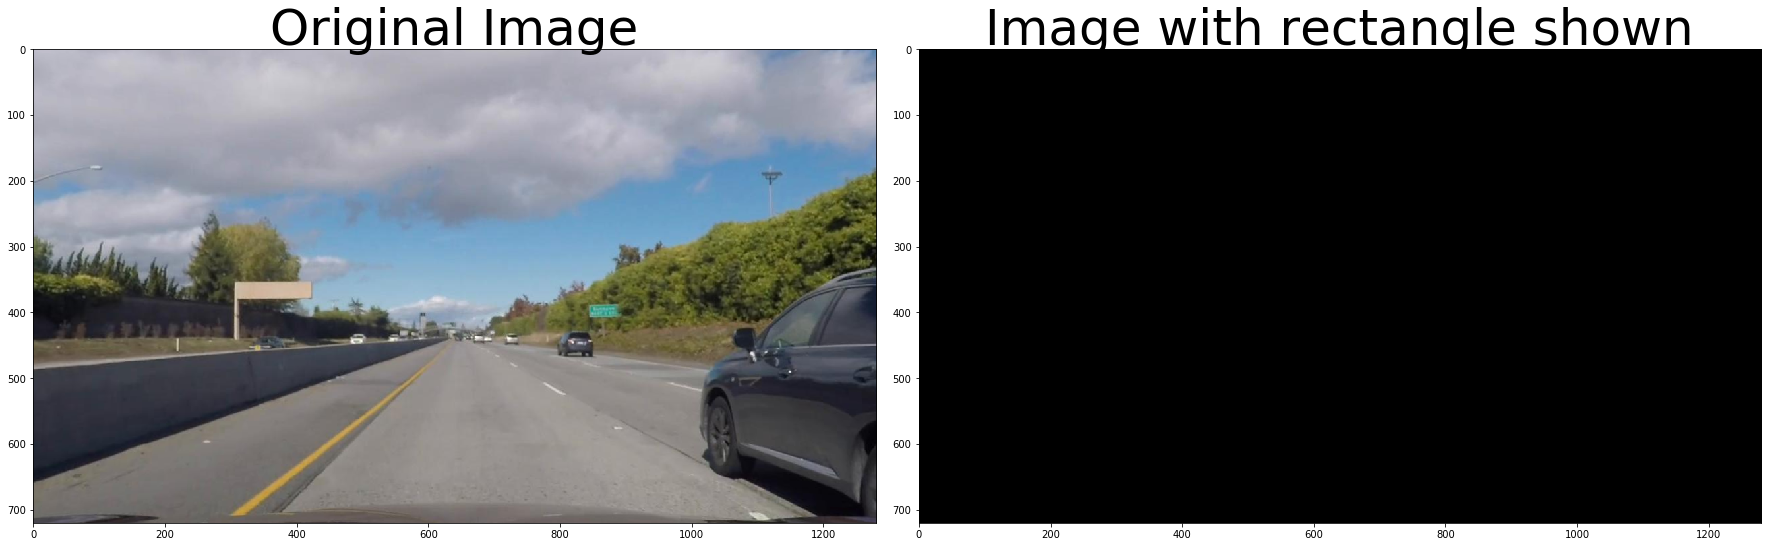

In [17]:
# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(LeftLane.windowingImage, cv2.COLOR_GRAY2RGB))
ax2.set_title('Image with rectangle shown', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)